In [1]:
%run 00_analysis_config.ipynb

Welcome to JupyROOT 6.22/02

RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



In [2]:
# modules in this directory
import visualization, util, event, cutflow, detector
importlib.reload(event)
importlib.reload(visualization)
importlib.reload(util)
importlib.reload(detector)
import visualization as vis

import lsfit
reload(lsfit)

import include_modules_root as rt
import gen_auxiliary as GAX
import Kalman_tom


In [3]:
# Figure save path prefix
savefig.fig_prefix = "plots/singletrack_"    # It's good to keep figures in a separate folder. Can also be set to None.
savefig.SAVE = False         # Use this flag to turn the figure saving on or off, so that you don't need to modify all notebook to save figure.

In [4]:
eta_min=np.arctan(65.5/169.5)
eta_min_eff=np.arctan((65.5+20)/169.5)
eta_max=np.arctan((65.5+30)/69.5)
eta_max_eff=np.arctan((65.5+20)/69.5)
phi=np.arctan(50/69.5)
cms=util.coord_cms2sim([0,0,0])
det_cent=util.coord_det2sim([4.5,0,-12.5])
r=det_cent-cms
sumr=np.sqrt(np.sum(r**2))
r/sumr

array([ 0.86175551,  0.        , -0.50732381])

In [5]:
import random
def spherepicking(n):
    while True:           #to get rid off [0,0,0,0] case
        l = [random.gauss(0, 1) for i in range(n)]
        sumsq = sum([x * x for x in l])
        if sumsq > 0:
            break
    norm = 1.0 / math.sqrt(sumsq)
    pt = [x * norm for x in l]
    return pt

print(spherepicking(4))


[-0.17465435131547388, 0.8609676242510395, -0.39633798332917125, -0.26673359467576924]


In [ ]:
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
p_unit=[]
for i in range(1000):
    pt=spherepicking(4)     
    p_unit.append((np.array([pt[0], pt[1], -pt[2]])))

    ax.scatter(*p_unit[i])
ax.set_aspect('auto')
plt.show()

### Generate simulation script

The script is then submitted with the python file in scripts/submit_jobs_singletrack_large_angle.py

In [ ]:
#-------------------
reload(GAX)
# 1. Gun at the center of the module
#(nevents,ID,GeV,name)
GAX.Vertex_Gun(60000,11,100,"100_GeV_ele")
GAX.Vertex_Gun(60000,211,100,"100_GeV_pion") 

### Check the angle range

In [ ]:
file=GAX.get_newest("/home/cfpuser/Mathusla/Mathusla_Effeciency_Grid-main/Data/Grid/Angular")
filenames = [f"/home/cfpuser/Mathusla/Mathusla_Effeciency_Grid-main/Data/Grid/Angular/20230605/{file}/run0.root",f"{file}/muon_100_GeV_CMS//20230518/180557/run0.root",]
filenames_recon = [f"/home/cfpuser/Mathusla/Mathusla_Effeciency_Grid-main/Data/Grid/Angular/20230605/{file}/stat0.root",f"{file}/muon_100_GeV_CMS//20230518/180557/stat_seedmod.root",]
print("./tracker",filenames[0], f"/home/cfpuser/Mathusla/Mathusla_Effeciency_Grid-main/Data/Grid/Angular/20230605/{file}")

In [ ]:
tree_name = "box_run"
file="/home/cfpuser/Mathusla/Mathusla_Effeciency_Grid-main/Data/wide_angle/pion/1_Gev_pion/175915/run0.root"
vis.plot_multiple_events(file, tree_name, nevents=600)
#vis.plot_multiple_events(filenames[1], tree_name, nevents=600)


# Efficiency vs angle

In [ ]:
filenames =[] 

In [548]:
Data_Dir="/home/cfpuser/Mathusla/Mathusla_Effeciency_Grid-main/Data/wide_angle/Results"
entries = os.listdir(Data_Dir)
filenames=[]
for file in entries:
    filenames.append(file)
print(filenames)


['0.1_GeV_pion.root', '1_GeV_pion.root', '0.1_GeV_muon.root', '100_GeV_muon.root', '0.1_GeV_electron.root', '1_GeV_electron.root', '10_GeV_electron.root', '10_GeV_muon.root', '5_GeV_muon.root', '1_GeV_muon.root', '10_Gev_pion.root']


In [549]:
def Plot_eff(self,filename):
    reload(rt)
    self.bins={}
    for file in filename:
        self.bins[f"{file}_bincenters"]=[]
        self.bins[f"{file}_TIGHT"]=[]
        self.bins[f"{file}_LOOSER"]=[]
        data = lsfit.get_km(f"{Data_Dir}/{file}")
        data["theta"] = np.arccos(data["truth"][:,5]/np.sqrt(data["truth"][:,4]**2 + data["truth"][:,5]**2 + data["truth"][:,6]**2))
        recon = data["recon"]
        truth = data["truth"]
        diffx = recon[:,2]-truth[:,2]
        diffy = recon[:,0]-truth[:,0]
        diffvx = recon[:,6]-truth[:,6]
        diffvy = recon[:,4]-truth[:,4] 
        mask_TIGHT  = (np.abs(diffx)<5) & (np.abs(diffy)<5) & (np.abs(diffvx)<0.5) & (np.abs(diffvy)<0.5)
        mask_LOOSER = (np.abs(diffx)<10) & (np.abs(diffy)<10) & (np.abs(diffvx)<1) & (np.abs(diffvy)<1)   
        pass_=[]
        tot_=[]
        pass_t=[]
        n_cuts = 25
        bins_loc = np.linspace(-np.arctan(44.5/8), np.arctan(44.5/8), n_cuts+1)
        bincenters_loc = 0.5*(bins_loc[1:]+bins_loc[:-1])
        self.bins[f"{file}_bincenters"]=np.array(bincenters_loc)
        
        eff = []
        eff_t = []
        pass_=[]
        tot_=[]
        pass_t=[]
        for i in range(n_cuts):
            mask = (data["theta"]>bins_loc[i])&(data["theta"]<bins_loc[i+1])
            n_pass = sum(data["mask_recon_success"]&mask_LOOSER&mask)
            n_pass_t = sum(data["mask_recon_success"]&mask_TIGHT&mask)
            n_total = sum(mask)
            pass_.append(n_pass)
            pass_t.append(n_pass_t)
            tot_.append(n_total)
            eff.append(n_pass/n_total)
            eff_t.append(n_pass_t/n_total)
    
        track_efficiency=rt.BayesDivide(pass_,tot_)
        track_efficiency_t=rt.BayesDivide(pass_t,tot_)
        self.bins[f"{file}_TIGHT"]=np.array([eff_t,track_efficiency_t])
        self.bins[f"{file}_LOOSER"]=np.array([eff,track_efficiency])


In [550]:
Plot_eff(Plot_eff,filenames)

  0%|          | 0/58311 [00:00<?, ?it/s]/home/cfpuser/Mathusla/Mathusla_Effeciency_Grid-main/lsfit.py:249: RuntimeWarning: invalid value encountered in sqrt
  results_fit["recon_error"].append(np.sqrt(par_km_error))
100%|██████████| 58311/58311 [00:11<00:00, 5262.49it/s]
/home/cfpuser/Mathusla/Mathusla_Effeciency_Grid-main/lsfit.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  results_fit[key]=np.array(results_fit[key])
/home/cfpuser/.conda/envs/tracker/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in long_scalars
/home/cfpuser/.conda/envs/tracker/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in long_scalars
/home/cfpuser/.conda/envs/tracker/lib/python3.7/site-pack

In [552]:
bincenters=Plot_eff.bins['1_GeV_pion.root_bincenters']
#LOOSE
TR_pion_LOOSE=np.array([Plot_eff.bins["0.1_GeV_pion.root_LOOSER"],Plot_eff.bins['1_GeV_pion.root_LOOSER']])
TR_muon_LOOSE=np.array([Plot_eff.bins["0.1_GeV_muon.root_LOOSER"],Plot_eff.bins['1_GeV_muon.root_LOOSER'],Plot_eff.bins['5_GeV_muon.root_LOOSER'],Plot_eff.bins['10_GeV_muon.root_LOOSER'],Plot_eff.bins['100_GeV_muon.root_LOOSER']])
TR_ele_LOOSE=np.array([Plot_eff.bins["0.1_GeV_electron.root_LOOSER"],Plot_eff.bins['1_GeV_electron.root_LOOSER'],Plot_eff.bins['10_GeV_electron.root_LOOSER']])
#TIGHT
TR_pion_TIGHT=np.array([Plot_eff.bins["0.1_GeV_pion.root_TIGHT"],Plot_eff.bins['1_GeV_pion.root_TIGHT']])
TR_muon_TIGHT=np.array([Plot_eff.bins["0.1_GeV_muon.root_TIGHT"],Plot_eff.bins['1_GeV_muon.root_TIGHT'],Plot_eff.bins['5_GeV_muon.root_TIGHT'],Plot_eff.bins['10_GeV_muon.root_TIGHT'],Plot_eff.bins['100_GeV_muon.root_TIGHT']])
TR_ele_TIGHT=np.array([Plot_eff.bins["0.1_GeV_electron.root_TIGHT"],Plot_eff.bins['1_GeV_electron.root_TIGHT'],Plot_eff.bins['10_GeV_electron.root_TIGHT']])
#Energy Wise comparison
Cross_part_01=np.array([Plot_eff.bins["0.1_GeV_muon.root_LOOSER"],Plot_eff.bins["0.1_GeV_electron.root_LOOSER"],Plot_eff.bins["0.1_GeV_pion.root_LOOSER"]])
Cross_part_1=np.array([Plot_eff.bins["1_GeV_muon.root_LOOSER"],Plot_eff.bins["1_GeV_electron.root_LOOSER"],Plot_eff.bins["1_GeV_pion.root_LOOSER"]])
Cross_part_10=np.array([Plot_eff.bins["10_GeV_muon.root_LOOSER"],Plot_eff.bins['10_GeV_electron.root_LOOSER'],Plot_eff.bins["10_Gev_pion.root_LOOSER"]])


In [553]:
#Cross Particle Analysis


In [554]:
def Plot_Results(bincenters,track_efficiency,cut,part,title):
    energy=["0.1_GeV/c","1_GeV/c","5_GeV/c","10_GeV/c","100_GeV/c"]
    part=["$/mu","e-","$/pi"]
    i=0
    for effn in track_efficiency:
        plt.errorbar(bincenters/np.pi*180, effn[1][0],yerr=[effn[1][1],effn[1][2]],fmt=".", capsize=2)
        if part == part:
            plot(bincenters/np.pi*180,effn[0] ,label=f"{cut}_{part[i]}" )
        else:
            plot(bincenters/np.pi*180,effn[0] ,label=f"{cut}_{energy[i]}" )
        i=i+1
    angle_firstgap = np.array([np.arctan(4.5/12),np.arctan(5.5/7)]    )
    angle_secondgap = np.array([np.arctan(14.5/12),np.arctan(15.5/7)]    )

    

    axvspan(*angle_firstgap/np.pi*180, alpha=0.1)
    axvspan(*angle_secondgap/np.pi*180, alpha=0.3)

    xlabel(r"$\theta$ [$^{\circ}$]")
    ylabel("Efficiency")
    plt.title(f"{title}")
    legend(fontsize="8")
    ylim(-0.1,1)
    xlim(-2,80)
    plt.show()
    

findfont: Font family ['san-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['san-serif'] not found. Falling back to DejaVu Sans.


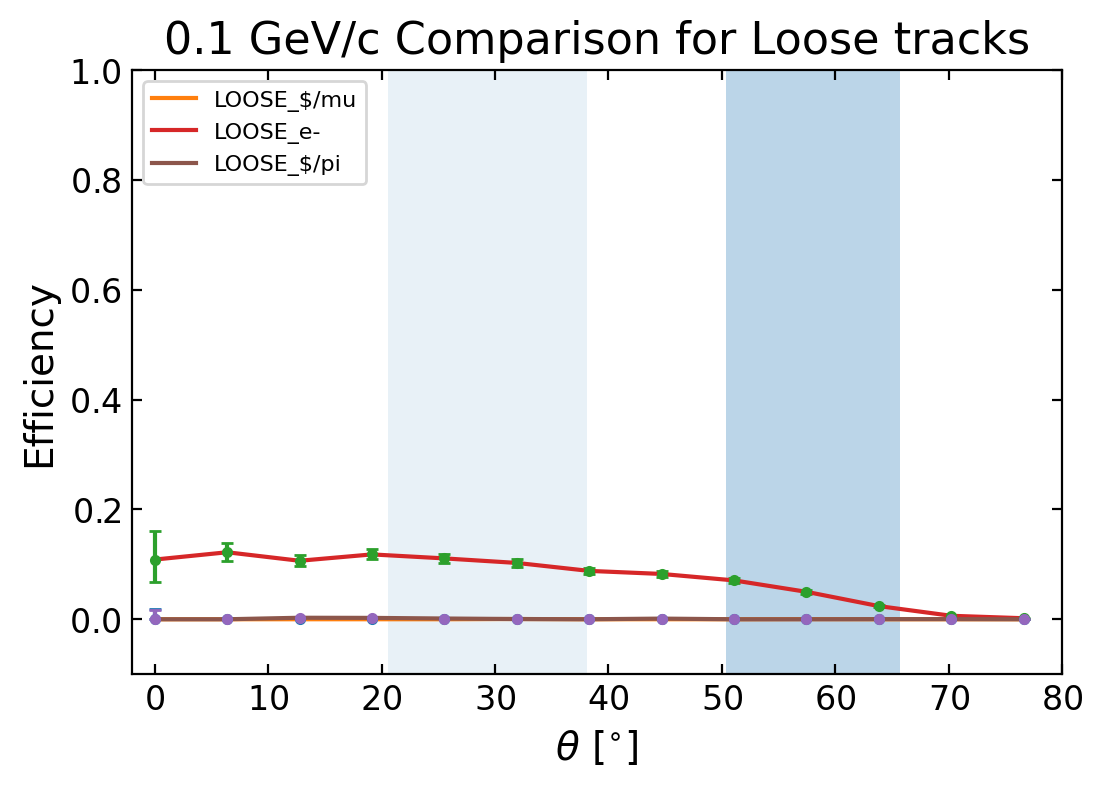

In [555]:
Plot_Results(Plot_eff.bins['1_GeV_muon.root_bincenters'],Cross_part_01,"LOOSE","part","0.1 GeV/c Comparison for Loose tracks")

In [557]:
data=lsfit.get_km("/home/cfpuser/Mathusla/Mathusla_Effeciency_Grid-main/Data/wide_angle/Results/1_GeV_muon.root")
data["theta"] = np.arccos(data["truth"][:,5]/np.sqrt(data["truth"][:,4]**2 + data["truth"][:,5]**2 + data["truth"][:,6]**2))
recon = data["recon"]
truth = data["truth"]
diffx = recon[:,2]-truth[:,2]
diffy = recon[:,0]-truth[:,0]
diffvx = recon[:,6]-truth[:,6]
diffvy = recon[:,4]-truth[:,4] 
mask_TIGHT  = (np.abs(diffx)<5) & (np.abs(diffy)<5) & (np.abs(diffvx)<0.5) & (np.abs(diffvy)<0.5)
mask_LOOSER = (np.abs(diffx)<10) & (np.abs(diffy)<10) & (np.abs(diffvx)<1) & (np.abs(diffvy)<1)

  0%|          | 0/53033 [00:00<?, ?it/s]/home/cfpuser/Mathusla/Mathusla_Effeciency_Grid-main/lsfit.py:249: RuntimeWarning: invalid value encountered in sqrt
  results_fit["recon_error"].append(np.sqrt(par_km_error))
100%|██████████| 53033/53033 [00:13<00:00, 3900.92it/s]
/home/cfpuser/Mathusla/Mathusla_Effeciency_Grid-main/lsfit.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  results_fit[key]=np.array(results_fit[key])


In [582]:
len(data["mask_recon_success"])

53033

/home/cfpuser/.conda/envs/tracker/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in long_scalars
/home/cfpuser/.conda/envs/tracker/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in long_scalars


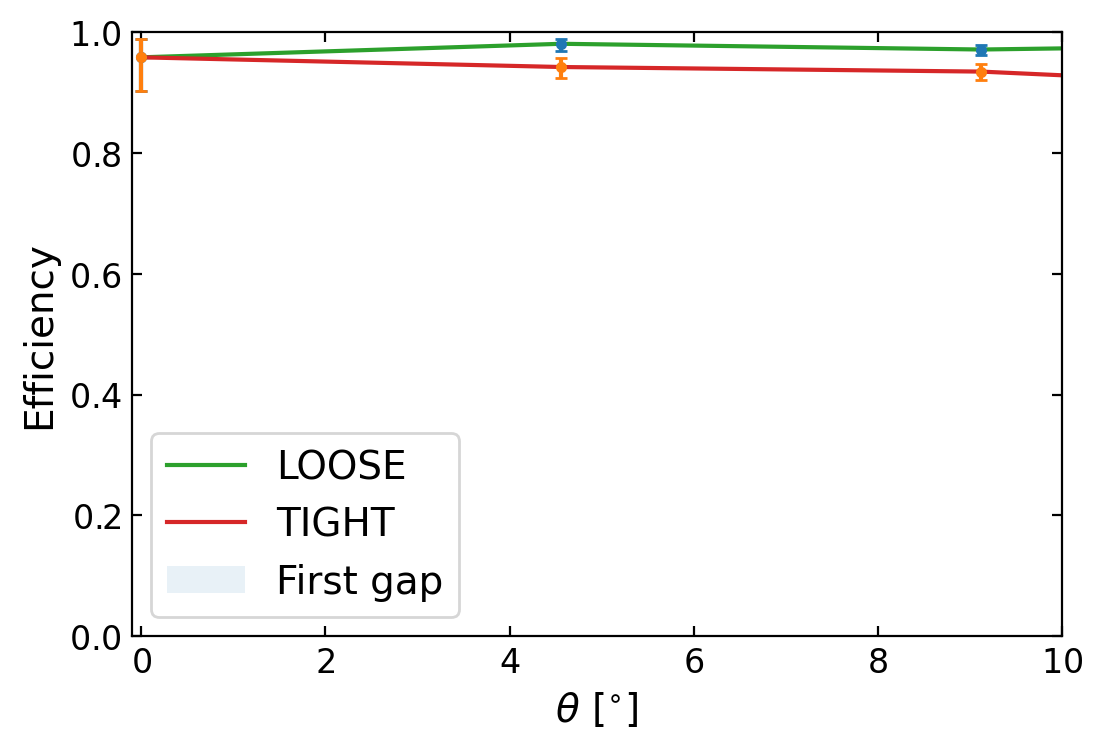

In [593]:
reload(rt)
pass_=[]
pass_t=[]
tot_=[]

n_cuts =35
bins = np.linspace(-np.arctan(44.5/8), np.arctan(44.5/8), n_cuts+1)
bincenters = 0.5*(bins[1:]+bins[:-1])
eff = []
eff_t = []
for i in range(n_cuts):
    mask = (data["theta"]>bins[i])&(data["theta"]<bins[i+1])
    n_pass = sum(data["mask_recon_success"]&mask_LOOSER&mask)
    n_pass_t = sum(data["mask_recon_success"]&mask_TIGHT&mask)
    n_total = sum(mask&data["mask_recon_success"])
    pass_.append(n_pass)
    pass_t.append(n_pass_t)
    tot_.append(n_total)
    eff.append(n_pass/n_total)
    eff_t.append(n_pass_t/n_total)
    
track_efficiency=rt.BayesDivide(pass_,tot_)
track_efficiency_t=rt.BayesDivide(pass_t,tot_)
plt.errorbar(bincenters/np.pi*180, track_efficiency[0],yerr=[track_efficiency[1],track_efficiency[2]],fmt=".", capsize=2)
plt.errorbar(bincenters/np.pi*180, track_efficiency_t[0],yerr=[track_efficiency_t[1],track_efficiency_t[2]],fmt=".", capsize=2)

angle_firstgap = np.array([np.arctan(4.5/12),np.arctan(5.5/7)]    )
angle_secondgap = np.array([np.arctan(14.5/12),np.arctan(15.5/7)]    )

plot(bincenters/np.pi*180,eff ,label="LOOSE" )
plot(bincenters/np.pi*180,eff_t,label="TIGHT")
axvspan(*angle_firstgap/np.pi*180, alpha=0.1,label="First gap")
axvspan(*angle_secondgap/np.pi*180, alpha=0.3)

xlabel(r"$\theta$ [$^{\circ}$]")
ylabel("Efficiency")
legend()
ylim(0,1)
xlim(-0.1,10)
plt.show()

In [533]:
reload(lsfit)
data=lsfit.get_km("/home/cfpuser/Mathusla/Mathusla_Effeciency_Grid-main/Data/Grid/Angular/20230605/063043/hermatic_floor.root")

  0%|          | 0/36555 [00:00<?, ?it/s]/home/cfpuser/Mathusla/Mathusla_Effeciency_Grid-main/lsfit.py:249: RuntimeWarning: invalid value encountered in sqrt
  results_fit["recon_error"].append(np.sqrt(par_km_error))
100%|██████████| 36555/36555 [00:13<00:00, 2763.34it/s]
/home/cfpuser/Mathusla/Mathusla_Effeciency_Grid-main/lsfit.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  results_fit[key]=np.array(results_fit[key])


In [534]:
mask=data["mask_recon_success"]
recon= data["recon"]
unc=data["recon_error"]
truth=data["truth"]
mag_vel=(np.sqrt(data["truth"][:,4]**2 + data["truth"][:,5]**2 + data["truth"][:,6]**2))
vel=[]
step=[]
recalc=[]
dist=[]
time=[]

for tt in range(len(truth)):
    
    #recalculating Truth at y_recon
    vel.append(truth[tt][4:]/(np.sqrt(data["truth"][tt][4]**2 +data["truth"][tt][5]**2 + data["truth"][tt][6]**2)))
    step.append(recon[tt][1]/vel[tt][1])
    recalc.append([truth[tt][0] + (truth[tt][1]-recon[tt][1])/truth[tt][5] * truth[tt][4], recon[tt][1] , truth[tt][2] + (truth[tt][1]-recon[tt][1])/truth[tt][5] * truth[tt][6]])
    #propgating time
    # we have t0 at y_truth, we get the distance between xyz truth and xyz frome the recalculated truth at recon layer
    #use mag velocity and distance to get del(t) new propgated time is t0 + del(t)  
    dist.append(np.sqrt((recalc[tt][0]-truth[tt][0])**2+(recalc[tt][1]-truth[tt][1])**2+(recalc[tt][2]-truth[tt][2])**2))
    time.append(truth[tt][3]+dist[tt]/mag_vel[tt])




In [540]:
axs

array([[<AxesSubplot:xlabel='Reco-truth, x0 [cm]', ylabel='counts'>,
        <AxesSubplot:xlabel='Reco-truth/unc, x0 [cm]', ylabel='counts'>],
       [<AxesSubplot:xlabel='Reco-truth, z0 [cm]', ylabel='counts'>,
        <AxesSubplot:xlabel='Reco-truth/unc, z0 [cm]', ylabel='counts'>],
       [<AxesSubplot:xlabel='Reco-truth, t0 [cm]', ylabel='counts'>,
        <AxesSubplot:xlabel='Reco-truth/unc, t0 [cm]', ylabel='counts'>],
       [<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>]], dtype=object)

<function matplotlib.pyplot.show>

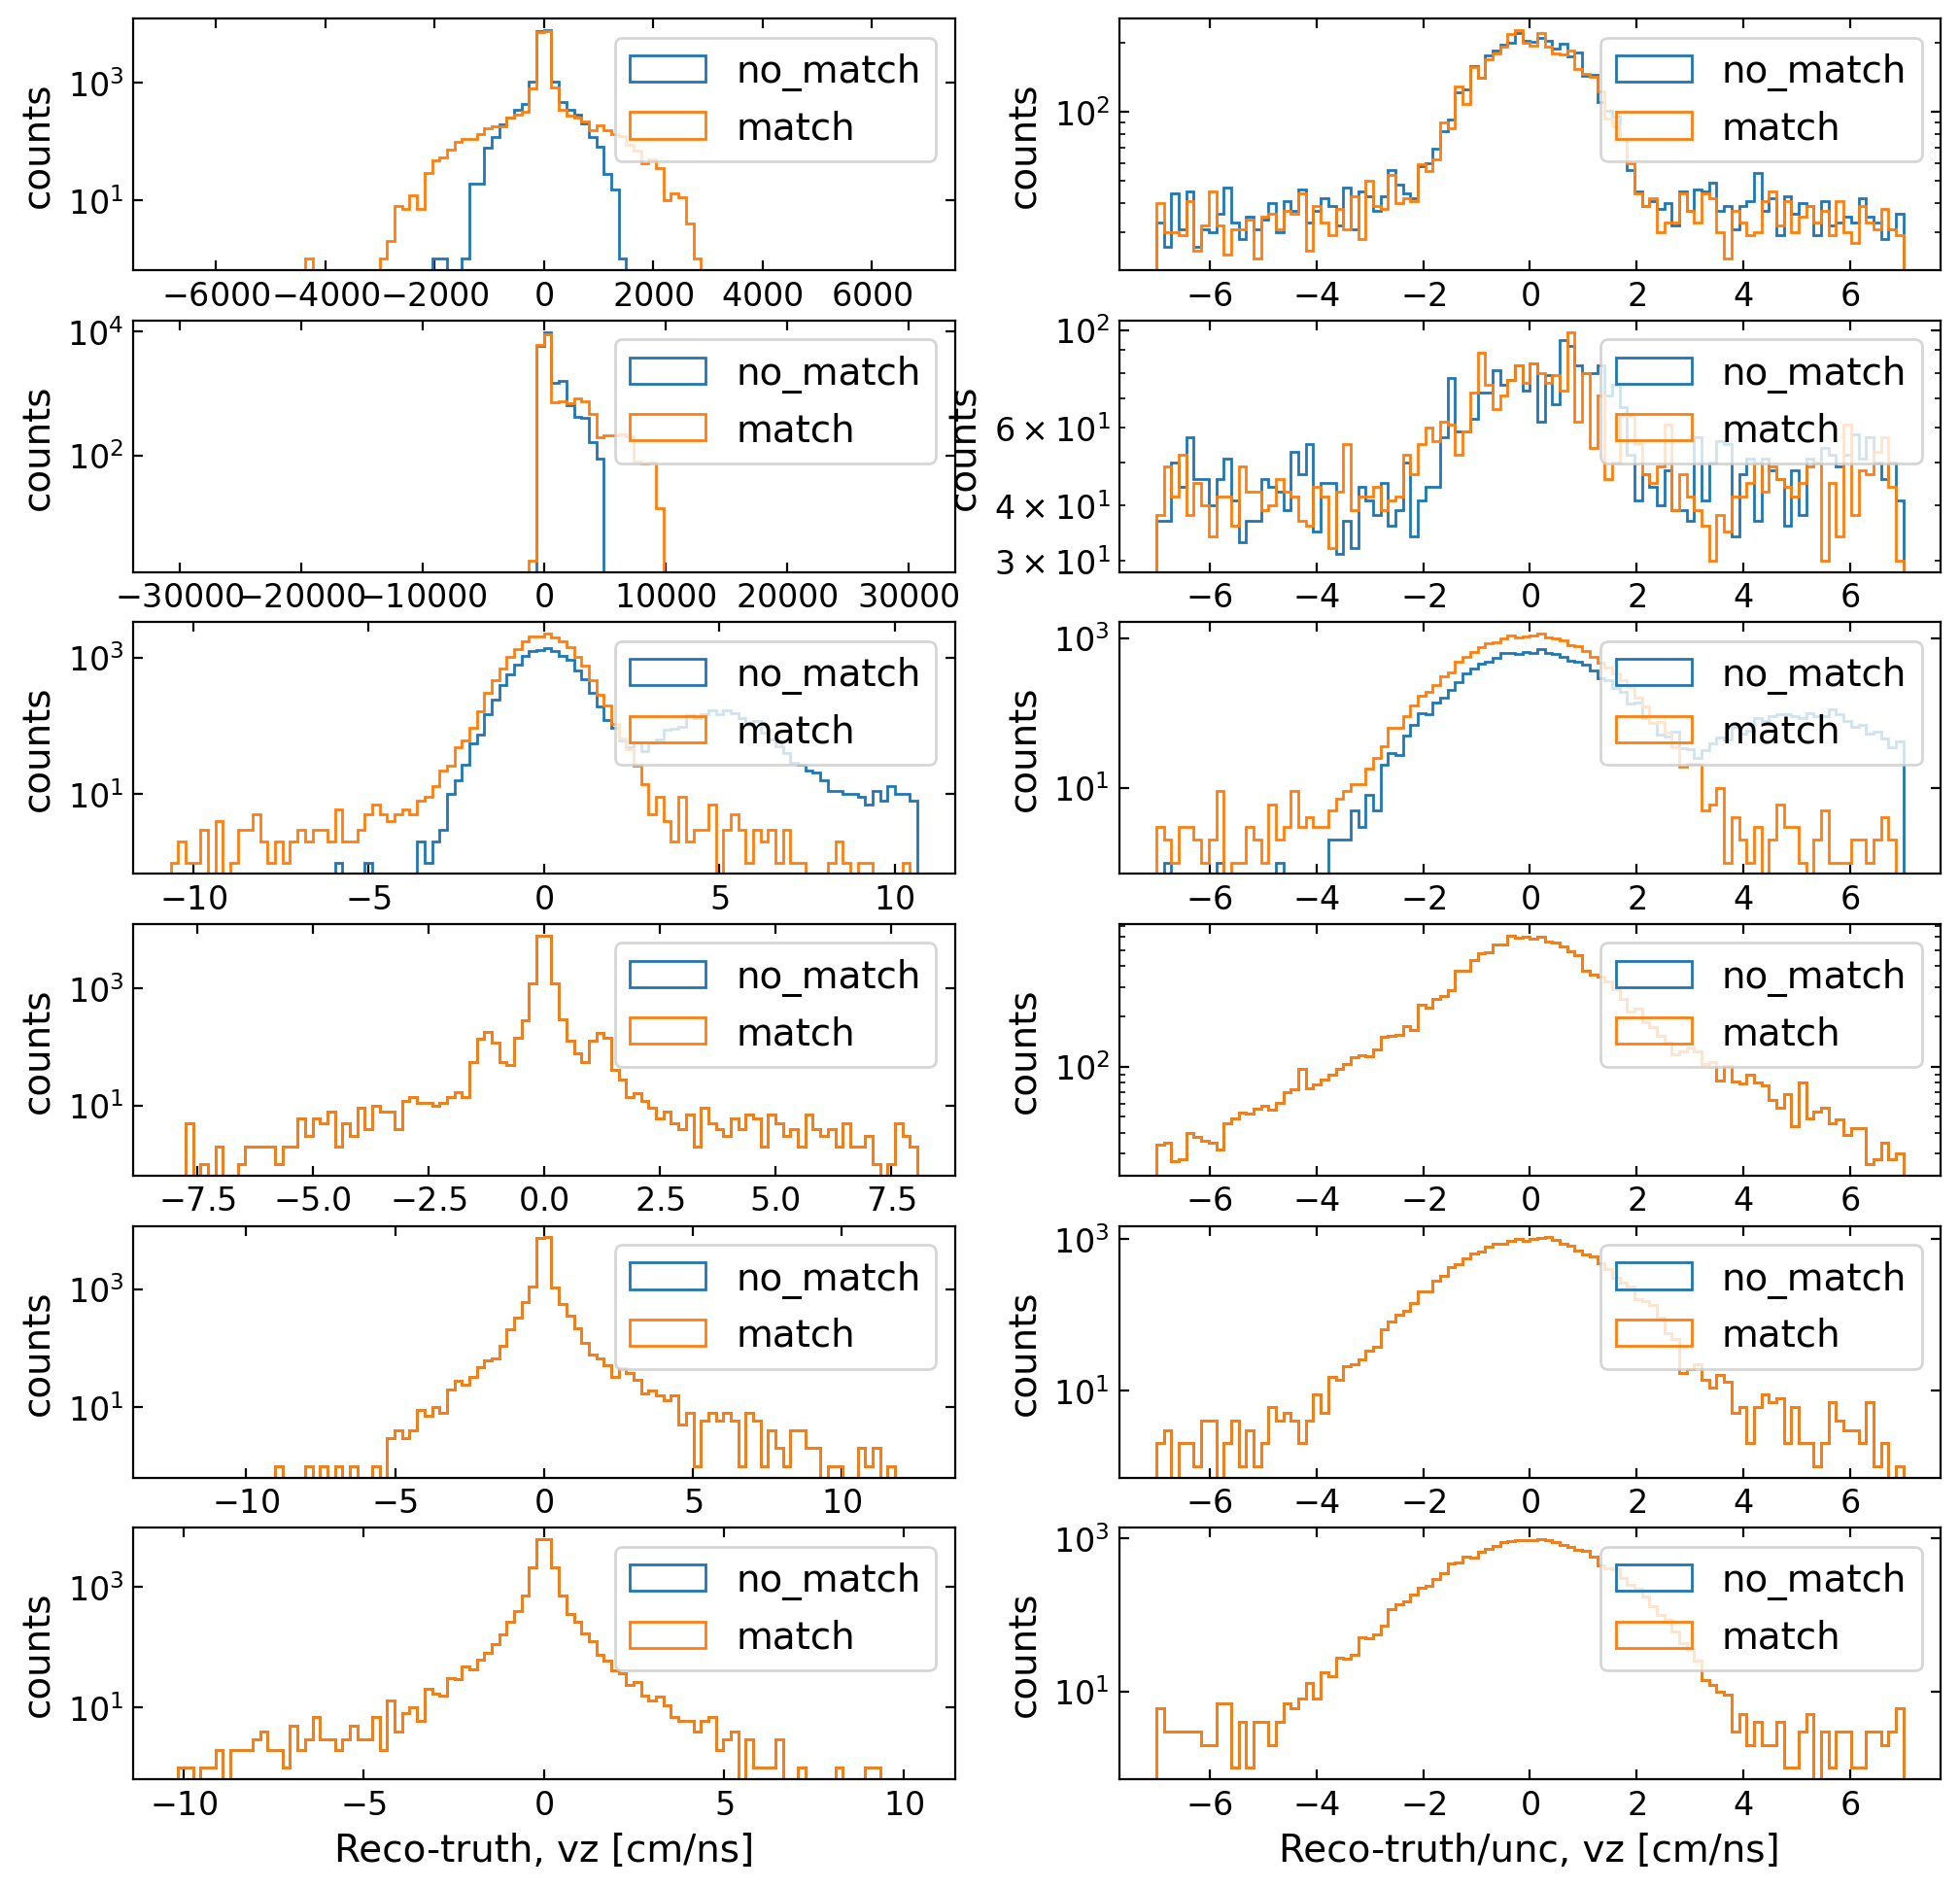

In [547]:
def pull(res, unc):
    return res/unc
par_names=['y0', 'z0', 'x0', 't0', 'vy', 'vz', 'vx'] # Use real world direction
par_unit= ["[cm]",'[cm]',"[cm]", "[ns]","[cm/ns]","[cm/ns]","[cm/ns]"]
fig,axs=plt.subplots(6,2,figsize=(12,12))
residual=[]
residual_old=[]
uncert=[]

for tt in range(len(mask)):
    if mask[tt]==True:
        residual_old.append([recon[tt][0]-truth[tt][0],recon[tt][2]-truth[tt][2],recon[tt][3]-truth[tt][3],recon[tt][4]-truth[tt][4],recon[tt][5]-truth[tt][5],recon[tt][6]-truth[tt][6]])
        residual.append([recon[tt][0]-recalc[tt][0],recon[tt][2]-recalc[tt][2],recon[tt][3]-time[tt],recon[tt][4]-truth[tt][4],recon[tt][5]-truth[tt][5],recon[tt][6]-truth[tt][6]])
        uncert.append([data["recon_error"][tt][0],data["recon_error"][tt][2],data["recon_error"][tt][3],data["recon_error"][tt][4],data["recon_error"][tt][5],data["recon_error"][tt][6]])
        
    else:
        continue
        
data["residual_km"]=np.array(residual)
data["residual_km0"]=np.array(residual_old)
data["unc"]=np.array(uncert)
res=data["residual_km"]
unc=data["unc"]
res_old=data["residual_km0"]
_range_pull=[-7,7]
#pull=np.array([pull(res[:,0],np.sqrt(unc[:,0])),pull(res[:,1],np.sqrt(unc[:,1])),pull(res[:,2],np.sqrt(unc[:,2]))])    
#pull_old=np.array([pull(res_old[:,0],np.sqrt(unc[:,0])),pull(res_old[:,1],np.sqrt(unc[:,1])),pull(res_old[:,2],np.sqrt(unc[:,2]))])


for ipar in range(6):
    _range=(np.percentile(res[:,ipar],1)*2,np.percentile(res[:,ipar],99)*2)
    _range=(-max(np.abs(_range))*2,max(np.abs(_range))*2)
    axs[ipar][0].hist(res_old[:,ipar],bins=100,range=_range,histtype="step",label="no_match");
    axs[ipar][0].hist(res[:,ipar],bins=100,range=_range,histtype="step",label="match");
    axs[ipar][0].set_xlabel(f"Reco-truth, {par_names[ipar]} {par_unit[ipar]}")
    axs[ipar][0].set_ylabel("counts")
    axs[ipar][0].set_yscale("log")
    axs[ipar][0].legend()    
    axs[ipar][1].hist(res_old[:,ipar]/unc[:,ipar],bins=100,range=_range_pull,histtype="step",label="no_match");
    axs[ipar][1].hist(res[:,ipar]/unc[:,ipar],bins=100,range=_range_pull,histtype="step",label="match");
    axs[ipar][1].set_xlabel(f"Reco-truth/unc, {par_names[ipar]} {par_unit[ipar]}")
    axs[ipar][1].set_ylabel("counts")
    axs[ipar][1].set_yscale("log")
    axs[ipar][1].legend()

plt.show

In [532]:
data["eta"] = np.arctanh(data["truth"][:,6]/np.sqrt(data["truth"][:,4]**2 +data["truth"][:,5]**2 + data["truth"][:,6]**2))
data["phi"] = np.arctan(data["truth"][:,4]/data["truth"][:,5])

In [ ]:
ev=event.Event("/home/cfpuser/Mathusla/Mathusla_Effeciency_Grid-main/Data/Grid/Angular/20230605/063043/stat0.root",EventNumber=8)
vis.plot_recon(ev)

In [ ]:
# Make a fixed range cut for tight and looser track
data=lsfit.get_km("/home/cfpuser/Mathusla/Mathusla_Effeciency_Grid-main/Data/Grid/Angular/20230605/063043/stat0.root")
recon = data["recon"]
truth = data["truth"]
diffx = recon[:,2]-truth[:,2]
diffy = recon[:,0]-truth[:,0]
diffvx = recon[:,6]-truth[:,6]
diffvy = recon[:,4]-truth[:,4] 
mask_TIGHT  = (np.abs(diffx)<5) & (np.abs(diffy)<5) & (np.abs(diffvx)<0.5) & (np.abs(diffvy)<0.5)
mask_LOOSER = (np.abs(diffx)<10) & (np.abs(diffy)<10) & (np.abs(diffvx)<1) & (np.abs(diffvy)<1)
mask_Super_LOOSE = (np.abs(diffx)<15) & (np.abs(diffy)<15) & (np.abs(diffvx)<1.5) & (np.abs(diffvy)<1.5)
eta=[]
phi=[]
data["eta"] = np.arctanh(data["truth"][:,6]/np.sqrt(data["truth"][:,4]**2 +data["truth"][:,5]**2 + data["truth"][:,6]**2))
data["phi"] = np.arctan(data["truth"][:,4]/data["truth"][:,5])
for i in range(len(data["eta"])):
    eta.append(data["eta"][i])
    phi.append(data["phi"][i])
n_cuts = 8
bins_eta = np.linspace(eta_min_eff+2.5*0.085,eta_max_eff, n_cuts+1)
bincenters_eta = 0.5*(bins_eta[1:]+bins_eta[:-1])
bins_phi = np.linspace(-0.6236+0.085, 0.6236-0.085, n_cuts+1)
bincenters_phi = 0.5*(bins_phi[1:]+bins_phi[:-1])
trackeff=[]

for i in range(n_cuts):
    eff = []
    mask = (eta>bins_eta[i])&(eta<bins_eta[i+1])
    for j in range(n_cuts):
        mask_phi = (phi>bins_phi[j])&(phi<bins_phi[j+1])    
        n_pass = sum(data["mask_recon_success"]&mask&mask_phi)
        n_total = sum(mask&mask_phi)
        eff.append(n_pass/n_total)
    trackeff.append(eff)
trr=np.array(trackeff)

In [ ]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


fig, ax = plt.subplots(figsize=(10,10))
nx, ny = trr.shape
indx, indy = np.arange(nx), np.arange(ny)
x, y = np.meshgrid(indx, indy)
im=ax.imshow(trr, interpolation='nearest',cmap="GnBu" ) # plot grid values

for xval, yval in zip(x.flatten(), y.flatten()):
    zval = trr[yval,xval]

    t = "{0:.2}".format(zval) # format value with 1 decimal point
    #c = 'w' if zval > 0.75 else 'k' # if dark-green, change text color to white
    ax.text(xval, yval, t, va='center', ha='center')
#set tick marks for grid
xlabels = np.round(bincenters_phi*57.2958,2)
ylabels = np.round(bincenters_eta*57.2958,2)
ax.set_xticks(indx+0.5) # offset x/y ticks so gridlines run on border of boxes
ax.set_yticks(indy+0.5)
ax.grid(ls='-', lw=2)
# the tick labels, if you want them centered need to be adjusted in
# this special way.
for a, ind, labels in zip((ax.xaxis, ax.yaxis), (indx, indy),
                          (xlabels, ylabels)):
    a.set_major_formatter(ticker.NullFormatter())
    a.set_minor_locator(ticker.FixedLocator(ind))
    a.set_minor_formatter(ticker.FixedFormatter(labels))
fig.colorbar(im)
ax.invert_yaxis()
label = ax.set_ylabel('Eta $^\circ$ ', fontsize=19, c="red")
label = ax.set_xlabel('phi $^\circ$ ', fontsize=19, c="red")
ax.xaxis.set_label_coords(0.5, -0.05)
ax.yaxis.set_label_coords(-0.09, 0.5)
fig.tight_layout()
ax.set_title("hemetic")
plt.show()
